In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import json
import music21 as mc
import numpy as np

import seaborn as sns
sns.set()

import random
random.seed(20201308)

PATH = 'drive/My Drive/000 STUDIA/MASTER/'
FILENAME = "datasets.zip"

# with open(os.path.join(PATH, "parse.json"), "r") as handle:
with open(os.path.join(PATH, "parse_2.json"), "r") as handle:
  parsed_data = json.load(handle)

def name_to_ps(name):
  return mc.pitch.Pitch(name).ps if name != "REST" else -1.0

def ps_to_name(ps):
  return mc.pitch.Pitch(ps).nameWithOctave if ps != -1.0 else "REST"

def unify_note(note):
  name, duration = note.split('_')
  pitch = name_to_ps(name)
  return f"{pitch}_{duration}"

TRUNCATE_CHORD = 4
def unify_chord(chord):
  names, duration = chord.split('_')
  new_names = []
  for name in names.split('.')[:TRUNCATE_CHORD]:
    new_names.append(str(name_to_ps(name)))
  return f"{'+'.join(new_names)}_{duration}"

if os.path.isfile(os.path.join(PATH, "test_idx.json")):
  with open(os.path.join(PATH, "test_idx.json"), "r") as handle:
    TEST_SELECT = json.load(handle)
else:
  TEST_SIZE = int(len(parsed_data['parse_success']) * 0.1)
  TEST_SELECT = random.sample(range(0, len(parsed_data['parse_success'])), TEST_SIZE)

  with open(os.path.join(PATH, "test_idx.json"), "w") as handle:
    json.dump(TEST_SELECT, handle)

# :D
TRAIN_SELECT = []
# ARTIST = "the-beatles"
ARTIST = "*"
REPEAT = 2

for idx, path in enumerate(parsed_data["parse_success"]):
  if (ARTIST == "*" or f"/{ARTIST}/" in path) and idx not in TEST_SELECT:
    TRAIN_SELECT.append(idx)

TRAIN_SONGS = []
notes_translated, chords_translated = [], []
for idx, (notes, chords) in enumerate(zip(parsed_data['notes'], parsed_data['chords'])):
  if idx not in TEST_SELECT and idx in TRAIN_SELECT:
    notes_translated.append([unify_note(n) for n in notes] * REPEAT)
    chords_translated.append([unify_chord(n) for n in chords] * REPEAT)
    TRAIN_SONGS.append(parsed_data["parse_success"][idx])

TEST_SONGS = []
notes_translated_test, chords_translated_test = [], []
for idx, (notes, chords) in enumerate(zip(parsed_data['notes'], parsed_data['chords'])):
  if idx in TEST_SELECT and idx not in TRAIN_SELECT:
    notes_translated_test.append([unify_note(n) for n in notes])
    chords_translated_test.append([unify_chord(n) for n in chords])
    TEST_SONGS.append(parsed_data["parse_success"][idx])

len(TRAIN_SONGS), len(TEST_SONGS)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(16155, 1794)

## Note-Chord alignment

In [3]:
def decode_note(note):
  pitch, duration = note.split('_')
  return pitch, float(duration)

def align_notes_to_chords(notes, chords):
  note_to_chord_align = []

  chord_idx = 0
  _, current_chord_duration = decode_note(chords[chord_idx])

  offset = 0.0
  for idx, note in enumerate(notes):
    current_align = []
    _, duration = decode_note(note)
    current_align.append(chord_idx)
    offset += duration

    while current_chord_duration < offset:
      if chord_idx == len(chords)-1:
        break
      chord_idx += 1
      _, nd = decode_note(chords[chord_idx])
      current_chord_duration += nd
      current_align.append(chord_idx)

    note_to_chord_align.append(current_align)

  return note_to_chord_align

# SAMPLE_IDX = 1
# sample_notes = notes_translated[SAMPLE_IDX] 
# sample_chords = chords_translated[SAMPLE_IDX]
# print(len(sample_notes), len(sample_chords))

# for idx, align in enumerate(align_notes_to_chords(sample_notes, sample_chords)[:10]):
#   print(sample_notes[idx])
#   aligned_chords = [sample_chords[a] for a in align]
#   print(sum(decode_note(chord)[1] for chord in aligned_chords))
#   print(align)
#   print()


In [4]:
NOTES_WINDOW = 8
CHORDS_WINDOW = 4
PITCHES_PER_CHORD = 4

START_STOP_TOKEN = "0.0_0.0"

def extract_notes_pitches_durations(notes_slice):
  input_pitches = []
  input_durations = []
  for n in notes_slice:
    pitch, duration = n.split('_')
    input_pitches.append(float(pitch))
    input_durations.append(float(duration))
  return input_pitches, input_durations

def filter_out_chords(chords, window_size):
  result = []
  durations = np.array([decode_note(chord)[1] for chord in chords[1:-1]])
  top_durations_arg = np.argpartition(durations, -(window_size-2))[-(window_size-2):]
  top_durations = durations[top_durations_arg]
  for idx, d in enumerate(durations):
    if d in top_durations and len(result) < window_size-2:
      result.append(chords[idx])
    if len(result) >= window_size:
      break

  # always include the first and the last chord  
  result = [chords[0], *result, chords[-1]]
  assert len(result) == window_size
  return result

def find_aligned_chords(aligns, target_idx):
  # this operates on INDICES of chords! this is what 'aligns' store
  target_aligned_chords = aligns[target_idx]
  j = 1
  while len(target_aligned_chords) < CHORDS_WINDOW and target_idx-j > 0:
    more_chords = aligns[target_idx-j]
    for ch in more_chords[::-1]:
      if ch not in target_aligned_chords:
        target_aligned_chords.insert(0, ch)
      if len(target_aligned_chords) == CHORDS_WINDOW:
        break
    j += 1
  
  j = 1
  next_chord = None
  while not next_chord and target_idx+j < len(aligns):
    next_note_aligned_chords = aligns[target_idx+j]
    for ch in next_note_aligned_chords:
      if ch != target_aligned_chords[-1]:
        next_chord = ch
        break
    j += 1

  return target_aligned_chords, next_chord

def chord_pitches_to_fixed(pitches):
  pitches = pitches.split('+')
  result = [0] * PITCHES_PER_CHORD
  for i in range(min(PITCHES_PER_CHORD, len(pitches))):
    result[i] = float(pitches[i])
  return result

def extract_chords_pitches_durations(chords_slice, next_chord):
  input_pitches = []
  input_durations = []

  # chords slice: up to CHORDS_WINDOW chords
  for chord in chords_slice:
    pitches, duration = chord.split('_')
    input_pitches.extend(chord_pitches_to_fixed(pitches))
    input_durations.append(float(duration))
  
  while len(input_pitches) != CHORDS_WINDOW*PITCHES_PER_CHORD:
    input_pitches.insert(0, 0)

  while len(input_durations) != CHORDS_WINDOW:
    input_durations.insert(0, 0)

  # next_chord: add this info at the end
  if next_chord:
    pitches, duration = next_chord.split('_')
    input_pitches.extend(chord_pitches_to_fixed(pitches))
    input_durations.append(float(duration))
  else:
    input_pitches.extend([0 for i in range(PITCHES_PER_CHORD)])
    input_durations.append(0)
  
  return input_pitches, input_durations

def prepare_raw_X_y(input_notes, input_chords):
  X_notes_raw, X_chords_raw, y_raw = [], [], []
  is_start, row_to_song_idx_map = [], []

  for s_dx, (notes, chords) in enumerate(zip(input_notes, input_chords)):
    align = align_notes_to_chords(notes, chords)
    
    for i in range(NOTES_WINDOW, len(notes)):

      # ____ NOTES
      notes_slice = notes[i-NOTES_WINDOW:i]
      input_pitches, input_durations = extract_notes_pitches_durations(notes_slice)
      assert len(input_pitches) == len(input_durations) == NOTES_WINDOW
      X_notes_raw.append([*input_pitches, *input_durations])

      # ____ CHORDS
      # indices
      target_aligned_chords, next_chord = find_aligned_chords(align, i)

      # transform to chords representations
      target_aligned_chords = [chords[a] for a in target_aligned_chords]
      if next_chord:
        next_chord = chords[next_chord]

      if len(target_aligned_chords) > CHORDS_WINDOW:
        target_aligned_chords = filter_out_chords(target_aligned_chords, CHORDS_WINDOW)

      # decode into custom numbers representation
      input_pitches, input_durations = extract_chords_pitches_durations(target_aligned_chords, next_chord)
      assert len(input_pitches) == (CHORDS_WINDOW+1)*PITCHES_PER_CHORD # +1: with next chord
      assert len(input_durations) == CHORDS_WINDOW+1
      X_chords_raw.append([*input_pitches, *input_durations])

      # ____ TARGET
      target = notes[i]
      y_raw.append(target)

      is_start.append(1 if i == NOTES_WINDOW else 0)
      row_to_song_idx_map.append(s_dx)

  assert len(X_notes_raw) == len(X_chords_raw) == len(y_raw) == len(row_to_song_idx_map)
  return X_notes_raw, X_chords_raw, y_raw, is_start, row_to_song_idx_map

X_train_n_raw, X_train_ch_raw, y_train_raw, is_start_train, row_to_song_idx_train = prepare_raw_X_y(notes_translated, chords_translated)
print(len(X_train_n_raw))

1654742


### Filter out too unfrequent targets

In [5]:
from collections import Counter

MIN_FREQ = 30 * REPEAT
UNKNOWN = "UNK"
y_counts = Counter(y_train_raw)

X_notes_new, X_chords_new, y_new, is_start_new, row_to_song_idx_new = [], [], [], [], []

for xn, xch, y, is_st, s_idx in zip(X_train_n_raw, X_train_ch_raw, y_train_raw, is_start_train, row_to_song_idx_train):
  X_notes_new.append(xn)
  X_chords_new.append(xch)
  
  if y_counts[y] >= MIN_FREQ:
    y_new.append(y)
  else:
    y_new.append("UNK")

  is_start_new.append(is_st)
  row_to_song_idx_new.append(s_idx)

print(len(set(y_train_raw)), len(set(y_new)))
print(len(y_train_raw), len(y_new))

1602 503
1654742 1654742


In [6]:
X_train_n_raw, X_train_ch_raw, y_train_raw, is_start_train, row_to_song_idx_train = X_notes_new, X_chords_new, y_new, is_start_new, row_to_song_idx_new
assert len(X_train_n_raw) == len(X_train_ch_raw) == len(y_train_raw) == len(is_start_train) == len(row_to_song_idx_train)
print(len(X_train_n_raw))

1654742


In [7]:
def prepare_input_X(X_notes_raw, X_chords_raw, is_start):

  X = np.zeros((len(X_notes_raw), NOTES_WINDOW*2 + (CHORDS_WINDOW+1)*PITCHES_PER_CHORD + (CHORDS_WINDOW+1) + 1), dtype=np.float16)
  # NOTE PITCH, NOTE DURATION, CHORD PITCHES, CHORD DURATION, IS_START

  for idx, (notes, chords, st) in enumerate(zip(X_notes_raw, X_chords_raw, is_start)):
    of = 0
    # NOTE PITCHES
    X[idx, of:of+NOTES_WINDOW] = notes[:NOTES_WINDOW]
    of += NOTES_WINDOW

    # NOTE DURATIONS
    X[idx, of:of+NOTES_WINDOW] = notes[NOTES_WINDOW:]
    of += NOTES_WINDOW

    # CHORDS PITCHES
    X[idx, of:of + (CHORDS_WINDOW+1)*PITCHES_PER_CHORD] = chords[:(CHORDS_WINDOW+1)*PITCHES_PER_CHORD]
    of += (CHORDS_WINDOW+1)*PITCHES_PER_CHORD

    # CHORDS DURATIONS
    X[idx, of:of + (CHORDS_WINDOW+1)] = chords[(CHORDS_WINDOW+1)*PITCHES_PER_CHORD:]
    of += (CHORDS_WINDOW+1)

    # IS START
    X[idx, -1] = st

  return X

from sklearn.preprocessing import RobustScaler

def scale_X(X, scaler=None):
  if not scaler:
    scaler = RobustScaler(quantile_range=(25.0, 75.0))
    scaler.fit(X)

  # UPDATE VALUES ONLY WHERE > 0? if there are zeros, DONT TOUCH IT!  i think this important
  new_X = scaler.transform(X)
  # new_X[X == 0.0] = 0.0
  
  return new_X, scaler

X_train = prepare_input_X(X_train_n_raw, X_train_ch_raw, is_start_train)
X_train, TRAIN_SCALER = scale_X(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
X_train[:1, :]

(1654742, 42, 1)


array([[[ -5.668 ],
        [ -2.166 ],
        [ -2.    ],
        [ -1.667 ],
        [ -5.668 ],
        [  0.    ],
        [  0.    ],
        [  0.    ],
        [ 29.    ],
        [ -0.5   ],
        [ -0.5   ],
        [  0.    ],
        [ 33.    ],
        [  0.    ],
        [  0.    ],
        [  0.    ],
        [  0.    ],
        [  0.4443],
        [ -0.5713],
        [  0.    ],
        [-13.2   ],
        [ -7.223 ],
        [ -9.14  ],
        [  0.    ],
        [  0.    ],
        [  0.5713],
        [ -0.8   ],
        [  0.    ],
        [ -0.8335],
        [ -0.1428],
        [  0.6   ],
        [  0.    ],
        [  0.8   ],
        [ -0.5557],
        [  0.    ],
        [  0.    ],
        [ -0.8   ],
        [ -1.25  ],
        [ -1.375 ],
        [  2.    ],
        [  0.4   ],
        [  1.    ]]], dtype=float16)

In [8]:
from keras.utils import np_utils

def prepare_input_y(y_raw, notes):
  # all_tokens = list(set([n for notes in notes for n in notes]))
  all_tokens = list(set(y_raw))
  token_to_id = {token : idx for idx, token in enumerate(all_tokens)}

  y = np_utils.to_categorical([token_to_id[token] for token in y_raw])
  return y, token_to_id

y_train, token_to_id = prepare_input_y(y_train_raw, notes_translated)
id_to_token = {token_to_id[token] : token for token in token_to_id}
print(y_train.shape)

(1654742, 503)


In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint

from tensorflow import keras

from keras.layers import Layer
import keras.backend as K

class attention(Layer):
  # https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/
  def __init__(self,**kwargs):
      super(attention,self).__init__(**kwargs)

  def build(self,input_shape):
      self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
      self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
      super(attention, self).build(input_shape)

  def call(self,x):
      et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
      at=K.softmax(et)
      at=K.expand_dims(at,axis=-1)
      output=x*at
      return K.sum(output,axis=1)

  def compute_output_shape(self,input_shape):
      return (input_shape[0],input_shape[-1])

  def get_config(self):
      return super(attention,self).get_config()

def get_model_dummy_notes_chords_stateless(X_shape, y_shape, lstm_size=256, drop=0.2, lr=1e-5):
  model = Sequential()
  model.add(LSTM(lstm_size, input_shape=(X_shape[1], X_shape[2])))
  if drop:
    model.add(Dropout(drop))
  model.add(Dense(y_shape[1], activation='softmax'))

  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss='categorical_crossentropy', optimizer=opt)

  return model, f"model_dummy_N+CH_{lstm_size}"

def get_model_dummy_notes_chords_stateful(X_shape, y_shape, lstm_size=128, drop=0.2, lr=1e-5):
  model = Sequential()
  model.add(LSTM(lstm_size, batch_input_shape=(1, 1, X_shape[1]), stateful=True))
  if drop:
    model.add(Dropout(drop))
  model.add(Dense(y_shape[1], activation='softmax'))

  opt = keras.optimizers.Adam(learning_rate=lr)
  # opt = keras.optimizers.RMSprop()

  model.compile(loss='categorical_crossentropy', optimizer=opt)
  return model, f"model_dummy_N+CH_{lstm_size}_stateful"

def get_model_giga_notes_chords_stateful(X_shape, y_shape, lstm_sizes=[512, 512], drop=0.2, lr=1e-5):
  model = Sequential()
  model.add(LSTM(lstm_sizes[0], batch_input_shape=(1, 1, X_shape[1]), stateful=True, return_sequences=True))
  if drop:
    model.add(Dropout(drop))
  for ls in lstm_sizes[1:-1]:
    model.add(LSTM(ls, return_sequences=True))
    if drop:
      model.add(Dropout(drop))
  model.add(LSTM(lstm_sizes[-1]))
  model.add(Dense(y_shape[1], activation='softmax'))

  opt = keras.optimizers.Adam(learning_rate=lr)
  # opt = keras.optimizers.RMSprop()

  model.compile(loss='categorical_crossentropy', optimizer=opt)
  return model, f"model_giga_N+CH_{'-'.join(map(str, lstm_sizes))}_stateful"

In [10]:
model, model_dir = get_model_dummy_notes_chords_stateful(X_train.shape, y_train.shape, lstm_size=128, drop=0.05, lr=1e-4)
# model, model_dir = get_model_giga_notes_chords_stateful(X_train.shape, y_train.shape, drop=0.15, lr=1e-3)

if not os.path.exists(os.path.join(PATH, model_dir)):
    os.makedirs(os.path.join(PATH, model_dir))

# filepath = os.path.join(PATH, model_dir, "weights-improvement-{epoch:02d}-{loss:.4f}.hdf5")
if ARTIST == "*":
  best_filename = f"ALL_best_notes-window={NOTES_WINDOW}_chords-window={CHORDS_WINDOW}.hdf5"
else:
  best_filename = f"{ARTIST.upper()}_best_notes-window={NOTES_WINDOW}_chords-window={CHORDS_WINDOW}.hdf5"

print(best_filename)
filepath = os.path.join(PATH, model_dir, best_filename)

# try:
#   model.load_weights(filepath)
#   print("Loaded weights!", filepath)
# except:
#   pass

model.summary()

ALL_best_notes-window=8_chords-window=4.hdf5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 128)                  87552     
_________________________________________________________________
dropout (Dropout)            (1, 128)                  0         
_________________________________________________________________
dense (Dense)                (1, 503)                  64887     
Total params: 152,439
Trainable params: 152,439
Non-trainable params: 0
_________________________________________________________________


### CUSTOM TRAIN

In [11]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
song_idx_list = list(set(row_to_song_idx_train))

N_EPOCHS = 10
SONGS_STEP = 200

best_loss = float('inf')
cum_loss = 0
loss_per_epoch = []

for e in range(N_EPOCHS):
  print(f"\n______ EPOCH {e} _______ \n")
  random.shuffle(song_idx_list)

  current_loss = 0.0
  for i, s_idx in enumerate(song_idx_list):
    indices = np.where(np.array(row_to_song_idx_train) == s_idx)[0]
    first = indices[0]
    last = indices[-1]
    
    sample_song = X_train[first:last+1, :, :]
    sample_y = y_train[first:last+1]

    if len(sample_song) == 0 or sample_song.shape[0] == 0:
      print("SAMPLE SONG IS 0 ??? ...")
      continue 

    hist = model.fit(sample_song.reshape(sample_song.shape[0], 1, -1), sample_y, shuffle=False, verbose=0, batch_size=1)
    model.reset_states()

    cum_loss += hist.history['loss'][0]
    current_loss += hist.history['loss'][0]
    if (i+1) % SONGS_STEP == 0:
      print(f"i={i+1}, L: {cum_loss / SONGS_STEP}")
      cum_loss = 0

  current_loss /= len(song_idx_list)
  loss_per_epoch.append(current_loss)
  if current_loss < best_loss:
    print(f"Loss improved from {best_loss} to {current_loss}, SAVE")
    best_loss = current_loss
    model.save(filepath)
    with open(filepath.replace(".hdf5", "_LOSS.json"), "w") as handle:
      json.dump(loss_per_epoch, handle)
    


______ EPOCH 0 _______ 



/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


i=200, L: 4.81605651140213
i=400, L: 4.4545307636260985
i=600, L: 4.431051090955735
i=800, L: 4.384236462116242
i=1000, L: 4.357537574768067
i=1200, L: 4.442244999408722
i=1400, L: 4.29555273771286
i=1600, L: 4.3160657274723055
i=1800, L: 4.277414004802704
i=2000, L: 4.382028611898423
i=2200, L: 4.311747188568115
i=2400, L: 4.32879242181778
i=2600, L: 4.280784685611724
i=2800, L: 4.238489031791687
i=3000, L: 4.319011093378067
i=3200, L: 4.359191807508469
i=3400, L: 4.365578101873398
i=3600, L: 4.341595920324326
i=3800, L: 4.271189162135125
i=4000, L: 4.361569050550461
i=4200, L: 4.316307374238968
i=4400, L: 4.298989579677582
i=4600, L: 4.298406149744988
i=4800, L: 4.264324994087219
i=5000, L: 4.368060814142227
i=5200, L: 4.572509975433349
i=5400, L: 4.304569913744927
i=5600, L: 4.364086631536484
i=5800, L: 4.609326632022857
i=6000, L: 4.287756875753403
i=6200, L: 4.398467288017273
i=6400, L: 4.3542353987693785
i=6600, L: 4.321293003559113
i=6800, L: 4.116679972410202
i=7000, L: 4.60502

## Prepare TEST

In [14]:
X_test_n_raw, X_test_ch_raw, y_test_raw, is_start_test, row_to_song_idx_test = prepare_raw_X_y(notes_translated_test, chords_translated_test)

X_test = prepare_input_X(X_test_n_raw, X_test_ch_raw, is_start_test)
print(X_test.shape, X_train.shape)

# y, token_to_id = prepare_input_y(y_raw, notes_translated)

X_test, _ = scale_X(X_test, scaler=TRAIN_SCALER)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test[:3, :, 0]

(85123, 42) (1654742, 42, 1)


array([[-0.5835, -5.668 , -1.    , -0.5835, -0.4167, -0.25  , -0.6665,
        -5.668 ,  7.    ,  7.    ,  1.    ,  0.    ,  1.    ,  2.    ,
         3.    , 15.    , -0.7144, -0.1111,  0.4285,  0.    , -1.    ,
        -0.1111,  0.4285,  0.    , -0.2   ,  0.2856,  1.4   ,  0.    ,
        -0.1666,  0.2856,  1.4   ,  0.    ,  0.    ,  0.4443, -0.5713,
         0.    ,  1.4   ,  1.5   ,  1.125 ,  1.    ,  1.2   ,  1.    ],
       [-5.668 , -1.    , -0.5835, -0.4167, -0.25  , -0.6665, -5.668 ,
        -1.    ,  7.    ,  1.    ,  0.    ,  1.    ,  2.    ,  3.    ,
        15.    ,  0.5   , -0.7144, -0.1111,  0.4285,  0.    , -1.    ,
        -0.1111,  0.4285,  0.    , -0.2   ,  0.2856,  1.4   ,  0.    ,
        -0.1666,  0.2856,  1.4   ,  0.    ,  0.    ,  0.4443, -0.5713,
         0.    ,  1.4   ,  1.5   ,  1.125 ,  1.    ,  1.2   ,  0.    ],
       [-1.    , -0.5835, -0.4167, -0.25  , -0.6665, -5.668 , -1.    ,
        -0.5835,  1.    ,  0.    ,  1.    ,  2.    ,  3.    , 15.    ,
    

### Its PREDICT time!

In [15]:
def get_duration(piece):
  _, duration = piece.split("_")
  return float(duration)

def chord_to_pitches_duration_fixed(chord):
  pitches, duration = chord.split("_")
  pitches = chord_pitches_to_fixed(pitches)
  return pitches, float(duration)

def extract_song_from_X(X, sample_song_idx, row_to_song_idx_map):
  indices = np.where(np.array(row_to_song_idx_map) == sample_song_idx)[0]
  first = indices[0]
  last = indices[-1]
  return X[first:last+1, :, :]

In [16]:
def unpack_vector(vec):
  # notes
  notes = vec[:NOTES_WINDOW*2]
  notes_pitches = notes[:NOTES_WINDOW]
  notes_durations = notes[NOTES_WINDOW:]
  
  # chords 
  CHORDS_WITH_NEXT_COUNT = CHORDS_WINDOW+1
  chords = vec[NOTES_WINDOW*2:NOTES_WINDOW*2+(CHORDS_WITH_NEXT_COUNT*PITCHES_PER_CHORD+CHORDS_WITH_NEXT_COUNT)]

  chords_pitches = chords[:CHORDS_WINDOW*PITCHES_PER_CHORD]
  next_chord_pitches = chords[CHORDS_WINDOW*PITCHES_PER_CHORD:CHORDS_WITH_NEXT_COUNT*PITCHES_PER_CHORD]

  chords_durations = chords[CHORDS_WITH_NEXT_COUNT*PITCHES_PER_CHORD:]
  next_chord_duration = chords_durations[-1]
  chords_durations = chords_durations[:-1]

  return notes_pitches, notes_durations, chords_pitches, chords_durations, next_chord_pitches, next_chord_duration

def find_current_chord_idx(chords, current_note_offset):
  # FIND CURRENT CHORD 'PLAYING'
  tmp_off = 0
  ch_idx = -1
  for idx, ch in enumerate(chords):
    duration = get_duration(ch)
    if tmp_off + duration >= current_note_offset:
      ch_idx = idx
      break
    tmp_off += duration
  return ch_idx

def gather_next_chords(current_note_offset, current_chords_offset, new_duration, current_chord_idx, chords):
  # WHAT TIME WE WILL BE AFTER ADDING PREDICTED NOTE?
  new_note_offset = current_note_offset + new_duration
  next_chords = []
  if new_note_offset >= current_chords_offset:
    # WE NEED TO LOAD NEXT CHORD
    tmp_off = current_chords_offset
    while tmp_off < new_note_offset and current_chord_idx+1 < len(chords):
      current_chord_idx += 1
      next_chord = chords[current_chord_idx]
      next_chords.append(next_chord)
      next_duration = get_duration(next_chord)
      tmp_off += next_duration
  return next_chords, current_chord_idx

def adjust_chords(new_chords, ch_idx, song_chords):
  prev = ch_idx - 1
  result = [ch for ch in new_chords]
  while len(result) < CHORDS_WINDOW and prev > 0:
    add_chord = song_chords[prev]
    if add_chord not in result:
      result.insert(0, add_chord)
    prev -= 1

  # filter out chords if we put too much into 'next chords' array
  if len(result) > CHORDS_WINDOW:
    result = filter_out_chords(result, CHORDS_WINDOW)
  return result

In [19]:
def predict(model, sample_song_idx, sample_song_notes, sample_song_chords, row_to_song_idx_map, X, scaler):
  song_length = sum(float(ch.split('_')[1]) for ch in sample_song_chords)
  print("Song Length:", song_length)

  sample_song = extract_song_from_X(X, sample_song_idx, row_to_song_idx_map)
  # TAKE SEED FROM THIS SONG
  seed = np.copy(sample_song[0])

  newsong_pitches = []
  newsong_durations = []

  inv_transform = scaler.inverse_transform(seed.reshape(1, -1))[0]
  for p in inv_transform[:NOTES_WINDOW]:
    newsong_pitches.append(p)

  for d in inv_transform[NOTES_WINDOW:NOTES_WINDOW*2]:
    newsong_durations.append(d)
  print("Start with:")
  print(list(zip(newsong_pitches, newsong_durations)))

  notes_pitches, notes_durations, chords_pitches, chords_durations, next_chord_pitches, next_chord_duration = unpack_vector(inv_transform)

  # WHERE ARE WE NOW?
  current_note_offset = np.sum(notes_durations)
  current_chords_offset = np.sum(chords_durations)

  model.reset_states()

  CLIP_DURATION = 8.0
  i = 0
  # for i in range(2000):
  while current_note_offset < song_length:
    i += 1

    # INVERSE TRANSFORM OF THIS SEED TO GET INFORMATION ABOUT MUSIC
    inv_transform = scaler.inverse_transform(seed.reshape(1, -1))[0]
    # unpack for convenience
    notes_pitches, notes_durations, chords_pitches, chords_durations, next_chord_pitches, next_chord_duration = unpack_vector(inv_transform)

    # # WHERE ARE WE NOW?
    # current_note_offset = np.sum(notes_durations)
    # current_chords_offset = np.sum(chords_durations)
    # print(current_note_offset, current_chords_offset)

    ch_idx = find_current_chord_idx(sample_song_chords, current_note_offset)

    # ________ MAKE A PREDICTION USING SEED
    pred = model.predict(seed.reshape(1, 1, -1))

    pred_token = id_to_token[np.argmax(pred)]
    # pred_pitch, pred_duration = id_to_token[np.argmax(pred)].split('_')

    if pred_token == UNKNOWN:
      print("\t UNK!")
      # dumb but I have no time :)
      prev_argmax = np.argmax(pred)
      pred[0, prev_argmax] = -1.0

    pred_pitch, pred_duration = list(map(float, id_to_token[np.argmax(pred)].split('_')))
    print(f"{i} prediction: {pred_pitch}, {pred_duration}")      

    pred_duration = min(CLIP_DURATION, pred_duration)
    newsong_pitches.append(pred_pitch)
    newsong_durations.append(pred_duration)
    # ________ PREDICTED
    current_note_offset += pred_duration
        
    next_chords, ch_idx = gather_next_chords(current_note_offset, current_chords_offset, pred_duration, ch_idx, sample_song_chords)
    if ch_idx+1 < len(sample_song_chords):
      future_chord = sample_song_chords[ch_idx+1]
    else:
      future_chord = None

    # 1. FILL IN NEW NOTES SHIFTED
    notes_pitches[:NOTES_WINDOW-1] = notes_pitches[1:]
    notes_pitches[NOTES_WINDOW-1] = pred_pitch

    notes_durations[:NOTES_WINDOW-1] = notes_durations[1:]
    notes_durations[NOTES_WINDOW-1] = pred_duration

    # 2. FILL IN NEW CHORDS :D MWAHAHAHA
    if not next_chords:
      pass
      # do nothing = amazing
    else:
      for nch in next_chords:
        current_chords_offset += get_duration(nch)
      next_chords = adjust_chords(next_chords, ch_idx, sample_song_chords)
      chords_pitches, chords_durations = extract_chords_pitches_durations(next_chords, future_chord)

    new_seed = scaler.transform(inv_transform.reshape(1, -1))
    new_seed = new_seed.reshape(new_seed.shape[0], new_seed.shape[1], 1)
    new_seed[:, -1, :] = 0
    seed = new_seed
  
  return newsong_pitches, newsong_durations

In [22]:
song_idx_list_test = list(set(row_to_song_idx_test))
random.shuffle(song_idx_list_test)

# SAMPLE A SONG
sample_song_idx = song_idx_list_test[0]
sample_song_chords = chords_translated_test[sample_song_idx]
sample_song_notes = notes_translated_test[sample_song_idx]

# lets make it double :)
sample_song_chords *= REPEAT

model.load_weights(filepath)
newsong_pitches, newsong_durations = predict(model, sample_song_idx, sample_song_notes, sample_song_chords, row_to_song_idx_test, X_test, TRAIN_SCALER)

Song Length: 64.0
Start with:
[(64.0, 0.5), (69.0, 0.5), (71.0, 0.5), (72.0, 0.75), (64.0, 0.25), (69.0, 0.25), (71.0, 0.25), (72.0, 0.25)]
1 prediction: 72.0, 0.5
2 prediction: 69.0, 0.5
3 prediction: 69.0, 0.5
4 prediction: 69.0, 0.5
5 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

6 prediction: 69.0, 0.5
7 prediction: 69.0, 0.5
8 prediction: 69.0, 0.5
9 prediction: 69.0, 0.5
10 prediction: 69.0, 0.5
11 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

12 prediction: 69.0, 0.5
13 prediction: 69.0, 0.5
14 prediction: 69.0, 0.5
15 prediction: 69.0, 0.5
16 prediction: 69.0, 0.5
17 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

18 prediction: 69.0, 0.5
19 prediction: 69.0, 0.5
20 prediction: 69.0, 0.5
21 prediction: 69.0, 0.5
22 prediction: 69.0, 0.5
23 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

24 prediction: 69.0, 0.5
25 prediction: 69.0, 0.5
26 prediction: 69.0, 0.5
27 prediction: 69.0, 0.5
28 prediction: 69.0, 0.5
29 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

30 prediction: 69.0, 0.5
31 prediction: 69.0, 0.5
32 prediction: 69.0, 0.5
33 prediction: 69.0, 0.5
34 prediction: 69.0, 0.5
35 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

36 prediction: 69.0, 0.5
37 prediction: 69.0, 0.5
38 prediction: 69.0, 0.5
39 prediction: 69.0, 0.5
40 prediction: 69.0, 0.5
41 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

42 prediction: 69.0, 0.5
43 prediction: 69.0, 0.5
44 prediction: 69.0, 0.5
45 prediction: 69.0, 0.5
46 prediction: 69.0, 0.5
47 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

48 prediction: 69.0, 0.5
49 prediction: 69.0, 0.5
50 prediction: 69.0, 0.5
51 prediction: 69.0, 0.5
52 prediction: 69.0, 0.5
53 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

54 prediction: 69.0, 0.5
55 prediction: 69.0, 0.5
56 prediction: 69.0, 0.5
57 prediction: 69.0, 0.5
58 prediction: 69.0, 0.5
59 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

60 prediction: 69.0, 0.5
61 prediction: 69.0, 0.5
62 prediction: 69.0, 0.5
63 prediction: 69.0, 0.5
64 prediction: 69.0, 0.5
65 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

66 prediction: 69.0, 0.5
67 prediction: 69.0, 0.5
68 prediction: 69.0, 0.5
69 prediction: 69.0, 0.5
70 prediction: 69.0, 0.5
71 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

72 prediction: 69.0, 0.5
73 prediction: 69.0, 0.5
74 prediction: 69.0, 0.5
75 prediction: 69.0, 0.5
76 prediction: 69.0, 0.5
77 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

78 prediction: 69.0, 0.5
79 prediction: 69.0, 0.5
80 prediction: 69.0, 0.5
81 prediction: 69.0, 0.5
82 prediction: 69.0, 0.5
83 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

84 prediction: 69.0, 0.5
85 prediction: 69.0, 0.5
86 prediction: 69.0, 0.5
87 prediction: 69.0, 0.5
88 prediction: 69.0, 0.5
89 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

90 prediction: 69.0, 0.5
91 prediction: 69.0, 0.5
92 prediction: 69.0, 0.5
93 prediction: 69.0, 0.5
94 prediction: 69.0, 0.5
95 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

96 prediction: 69.0, 0.5
97 prediction: 69.0, 0.5
98 prediction: 69.0, 0.5
99 prediction: 69.0, 0.5
100 prediction: 69.0, 0.5
101 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

102 prediction: 69.0, 0.5
103 prediction: 69.0, 0.5
104 prediction: 69.0, 0.5
105 prediction: 69.0, 0.5
106 prediction: 69.0, 0.5
107 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

108 prediction: 69.0, 0.5
109 prediction: 69.0, 0.5
110 prediction: 69.0, 0.5
111 prediction: 69.0, 0.5
112 prediction: 69.0, 0.5
113 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

114 prediction: 69.0, 0.5
115 prediction: 69.0, 0.5
116 prediction: 69.0, 0.5
117 prediction: 69.0, 0.5
118 prediction: 69.0, 0.5
119 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

120 prediction: 69.0, 0.5
121 prediction: 69.0, 0.5
122 prediction: 69.0, 0.5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


### Save prediction

In [ ]:
def newsong_to_midistream(newsong_pitches, newsong_durations, sample_song_chords):
  newsong_stream = []
  off = 0.0

  for p, d in zip(newsong_pitches, newsong_durations):
    p, d = float(p), float(d)
    d = round(d, 2)
    if p != -1.0:
      new_note = mc.note.Note(p)
    else:
      new_note = mc.note.Rest()
    new_note.quarterLength = d
    newsong_stream.append(new_note)

    new_note.offset = off
    off += d

  off = 0.0
  for ch in sample_song_chords:
    pitches = ch.split('_')[0].split('+')
    d = float(ch.split('_')[1])
    if pitches[0] == "-1.0":
      new_chord = mc.note.Rest()
    else:
      new_chord = mc.chord.Chord([mc.note.Note(float(p)-12.0).nameWithOctave for p in pitches])
    new_chord.quarterLength = d
    newsong_stream.append(new_chord)

    new_chord.offset = off
    off += d
    
  return newsong_stream

In [ ]:
newsong_stream = newsong_to_midistream(newsong_pitches, newsong_durations, sample_song_chords)
midi_stream = mc.stream.Stream(newsong_stream)
midi_stream.write('midi', fp=f'notes-and-chords_{ARTIST}_TEST-{sample_song_idx}.mid')

'notes-and-chords_the-beatles_TEST-383.mid'

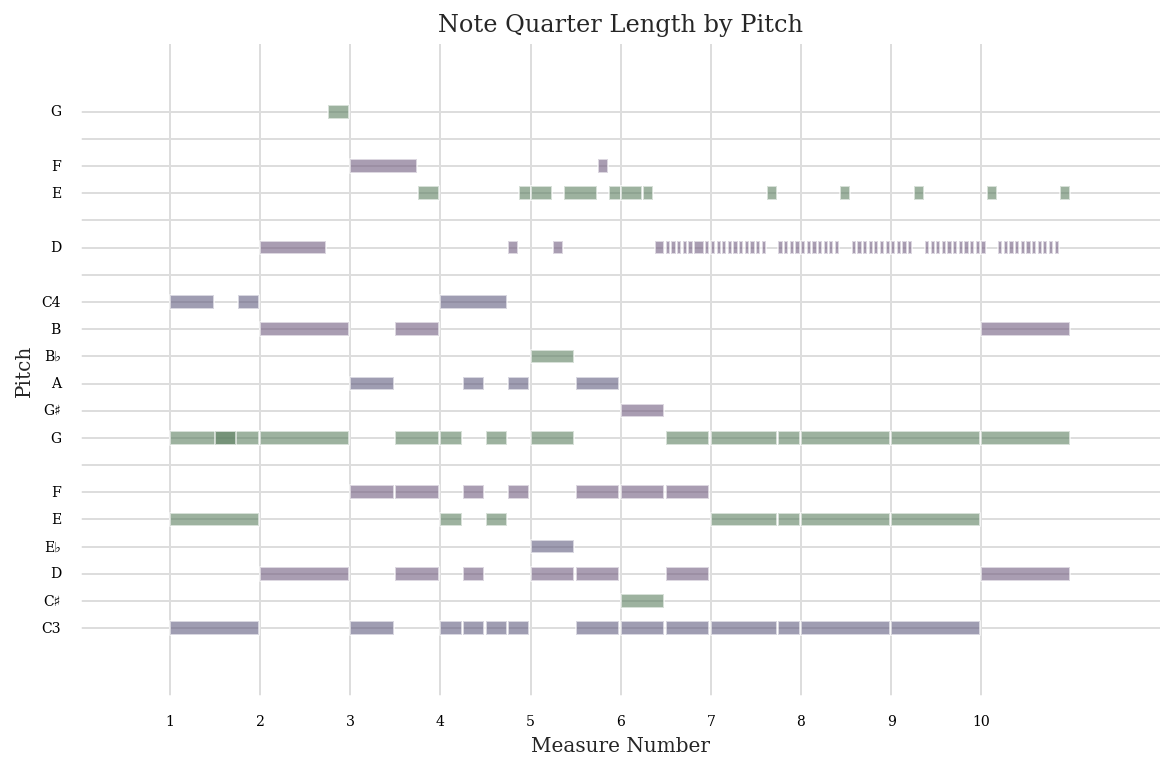

In [ ]:
midi_stream.measures(0, 10).plot()

# Predictions on the training data
> Did the model memorize?

In [ ]:
song_idx_list_train = list(set(row_to_song_idx_train))
random.shuffle(song_idx_list_train)

# SAMPLE A SONG
sample_song_idx = song_idx_list_train[0]
print(TRAIN_SONGS[sample_song_idx])

sample_song_chords = chords_translated[sample_song_idx]
sample_song_notes = notes_translated[sample_song_idx]
print(len(sample_song_chords), len(sample_song_notes))

# lets make it double :)
# REPEAT = 2
sample_song_chords *= REPEAT

newsong_pitches, newsong_durations = predict(model, sample_song_idx, sample_song_notes, sample_song_chords, row_to_song_idx_train, X_train, TRAIN_SCALER)

datasets/pianoroll/t/the-beatles/ob-la-di-ob-la-da/bridge_nokey.mid
8 118
Song Length: 256.0
1 prediction: 67.0, 1.0
2 prediction: 69.0, 1.0
3 prediction: 72.0, 1.0
4 prediction: -1.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

5 prediction: 64.0, 0.5
6 prediction: 69.0, 1.0
7 prediction: -1.0, 1.0
8 prediction: 60.0, 2.0
9 prediction: 64.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

10 prediction: 62.0, 1.0
11 prediction: 64.0, 0.5
12 prediction: 58.0, 1.0
13 prediction: 59.0, 1.0
14 prediction: 60.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

15 prediction: 59.0, 1.0
16 prediction: 57.0, 1.0
17 prediction: 57.0, 1.0
18 prediction: 59.0, 1.0
19 prediction: 57.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

20 prediction: 57.0, 1.0
21 prediction: 59.0, 1.0
22 prediction: 57.0, 1.0
23 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

24 prediction: 59.0, 1.0
25 prediction: 59.0, 1.0
26 prediction: 59.0, 1.0
27 prediction: 59.0, 1.0
28 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

29 prediction: 59.0, 1.0
30 prediction: 59.0, 1.0
31 prediction: 59.0, 1.0
32 prediction: 59.0, 1.0
33 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

34 prediction: 59.0, 1.0
35 prediction: 59.0, 1.0
36 prediction: 59.0, 1.0
37 prediction: 59.0, 1.0
38 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

39 prediction: 59.0, 1.0
40 prediction: 59.0, 1.0
41 prediction: 59.0, 1.0
42 prediction: 59.0, 1.0
43 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

44 prediction: 59.0, 1.0
45 prediction: 59.0, 1.0
46 prediction: 59.0, 1.0
47 prediction: 59.0, 1.0
48 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

49 prediction: 59.0, 1.0
50 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


51 prediction: 59.0, 1.0
52 prediction: 59.0, 1.0
53 prediction: 59.0, 1.0
54 prediction: 59.0, 1.0
55 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

56 prediction: 59.0, 1.0
57 prediction: 59.0, 1.0
58 prediction: 59.0, 1.0
59 prediction: 59.0, 1.0
60 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

61 prediction: 59.0, 1.0
62 prediction: 59.0, 1.0
63 prediction: 59.0, 1.0
64 prediction: 59.0, 1.0
65 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

66 prediction: 59.0, 1.0
67 prediction: 59.0, 1.0
68 prediction: 59.0, 1.0
69 prediction: 59.0, 1.0
70 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

71 prediction: 59.0, 1.0
72 prediction: 59.0, 1.0
73 prediction: 59.0, 1.0
74 prediction: 59.0, 1.0
75 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

76 prediction: 59.0, 1.0
77 prediction: 59.0, 1.0
78 prediction: 59.0, 1.0
79 prediction: 59.0, 1.0
80 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

81 prediction: 59.0, 1.0
82 prediction: 59.0, 1.0
83 prediction: 59.0, 1.0
84 prediction: 59.0, 1.0
85 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

86 prediction: 59.0, 1.0
87 prediction: 59.0, 1.0
88 prediction: 59.0, 1.0
89 prediction: 59.0, 1.0
90 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

91 prediction: 59.0, 1.0
92 prediction: 59.0, 1.0
93 prediction: 59.0, 1.0
94 prediction: 59.0, 1.0
95 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

96 prediction: 59.0, 1.0
97 prediction: 59.0, 1.0
98 prediction: 59.0, 1.0
99 prediction: 59.0, 1.0
100 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

101 prediction: 59.0, 1.0
102 prediction: 59.0, 1.0
103 prediction: 59.0, 1.0
104 prediction: 59.0, 1.0
105 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

106 prediction: 59.0, 1.0
107 prediction: 59.0, 1.0
108 prediction: 59.0, 1.0
109 prediction: 59.0, 1.0
110 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

111 prediction: 59.0, 1.0
112 prediction: 59.0, 1.0
113 prediction: 59.0, 1.0
114 prediction: 59.0, 1.0
115 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

116 prediction: 59.0, 1.0
117 prediction: 59.0, 1.0
118 prediction: 59.0, 1.0
119 prediction: 59.0, 1.0
120 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

121 prediction: 59.0, 1.0
122 prediction: 59.0, 1.0
123 prediction: 59.0, 1.0
124 prediction: 59.0, 1.0
125 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

126 prediction: 59.0, 1.0
127 prediction: 59.0, 1.0
128 prediction: 59.0, 1.0
129 prediction: 59.0, 1.0
130 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

131 prediction: 59.0, 1.0
132 prediction: 59.0, 1.0
133 prediction: 59.0, 1.0
134 prediction: 59.0, 1.0
135 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

136 prediction: 59.0, 1.0
137 prediction: 59.0, 1.0
138 prediction: 59.0, 1.0
139 prediction: 59.0, 1.0
140 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

141 prediction: 59.0, 1.0
142 prediction: 59.0, 1.0
143 prediction: 59.0, 1.0
144 prediction: 59.0, 1.0
145 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

146 prediction: 59.0, 1.0
147 prediction: 59.0, 1.0
148 prediction: 59.0, 1.0
149 prediction: 59.0, 1.0
150 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

151 prediction: 59.0, 1.0
152 prediction: 59.0, 1.0
153 prediction: 59.0, 1.0
154 prediction: 59.0, 1.0
155 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

156 prediction: 59.0, 1.0
157 prediction: 59.0, 1.0
158 prediction: 59.0, 1.0
159 prediction: 59.0, 1.0
160 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

161 prediction: 59.0, 1.0
162 prediction: 59.0, 1.0
163 prediction: 59.0, 1.0
164 prediction: 59.0, 1.0
165 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

166 prediction: 59.0, 1.0
167 prediction: 59.0, 1.0
168 prediction: 59.0, 1.0
169 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

170 prediction: 59.0, 1.0
171 prediction: 59.0, 1.0
172 prediction: 59.0, 1.0
173 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

174 prediction: 59.0, 1.0
175 prediction: 59.0, 1.0
176 prediction: 59.0, 1.0
177 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

178 prediction: 59.0, 1.0
179 prediction: 59.0, 1.0
180 prediction: 59.0, 1.0
181 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

182 prediction: 59.0, 1.0
183 prediction: 59.0, 1.0
184 prediction: 59.0, 1.0
185 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

186 prediction: 59.0, 1.0
187 prediction: 59.0, 1.0
188 prediction: 59.0, 1.0
189 prediction: 59.0, 1.0
190 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

191 prediction: 59.0, 1.0
192 prediction: 59.0, 1.0
193 prediction: 59.0, 1.0
194 prediction: 59.0, 1.0
195 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

196 prediction: 59.0, 1.0
197 prediction: 59.0, 1.0
198 prediction: 59.0, 1.0
199 prediction: 59.0, 1.0
200 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

201 prediction: 59.0, 1.0
202 prediction: 59.0, 1.0
203 prediction: 59.0, 1.0
204 prediction: 59.0, 1.0
205 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

206 prediction: 59.0, 1.0
207 prediction: 59.0, 1.0
208 prediction: 59.0, 1.0
209 prediction: 59.0, 1.0
210 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

211 prediction: 59.0, 1.0
212 prediction: 59.0, 1.0
213 prediction: 59.0, 1.0
214 prediction: 59.0, 1.0
215 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

216 prediction: 59.0, 1.0
217 prediction: 59.0, 1.0
218 prediction: 59.0, 1.0
219 prediction: 59.0, 1.0
220 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

221 prediction: 59.0, 1.0
222 prediction: 59.0, 1.0
223 prediction: 59.0, 1.0
224 prediction: 59.0, 1.0
225 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

226 prediction: 59.0, 1.0
227 prediction: 59.0, 1.0
228 prediction: 59.0, 1.0
229 prediction: 59.0, 1.0
230 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

231 prediction: 59.0, 1.0
232 prediction: 59.0, 1.0
233 prediction: 59.0, 1.0
234 prediction: 59.0, 1.0
235 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

236 prediction: 59.0, 1.0
237 prediction: 59.0, 1.0
238 prediction: 59.0, 1.0
239 prediction: 59.0, 1.0
240 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

241 prediction: 59.0, 1.0
242 prediction: 59.0, 1.0
243 prediction: 59.0, 1.0
244 prediction: 59.0, 1.0
245 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though t

246 prediction: 59.0, 1.0
247 prediction: 59.0, 1.0
248 prediction: 59.0, 1.0
249 prediction: 59.0, 1.0
250 prediction: 59.0, 1.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
newsong_stream = newsong_to_midistream(newsong_pitches, newsong_durations, sample_song_chords)
midi_stream = mc.stream.Stream(newsong_stream)
midi_stream.write('midi', fp=f'notes-and-chords_{ARTIST}_TRAIN-{sample_song_idx}.mid')

'notes-and-chords_the-beatles_TRAIN-111.mid'

## Some debugging

In [ ]:
import matplotlib.pyplot as plt

seed = np.copy(X_test[:1])
seed[:, -1, :] = 1
print("SEED:", seed)
prediction = model.predict(seed)

p = prediction.reshape(-1)
plt.scatter([i for i in range(len(p))], p)
plt.title("Sample model prediction")

In [ ]:

p_to_idx = list(zip(p, [i for i in range(len(p))]))
top_pred = sorted(p_to_idx, key=lambda x : -x[0])[:10]
for prob, id in top_pred:
  print(prob, ":", id_to_token[id])

# Non stateful model

In [ ]:
model, model_dir = get_model_dummy_notes_chords(lstm_size=512, drop=0.05)

if not os.path.exists(os.path.join(PATH, model_dir)):
    os.makedirs(os.path.join(PATH, model_dir))

# filepath = os.path.join(PATH, model_dir, "weights-improvement-{epoch:02d}-{loss:.4f}.hdf5")
best_filename = f"best_notes-window={NOTES_WINDOW}_chords-window={CHORDS_WINDOW}.hdf5"
print(best_filename)
filepath = os.path.join(PATH, model_dir, best_filename)
print(filepath)
# model.load_weights(filepath)
model.summary()

best_notes-window=8_chords-window=4.hdf5
drive/My Drive/000 STUDIA/MASTER/model_dummy_N+CH_512/best_notes-window=8_chords-window=4.hdf5
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 512)               1052672   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 141)               72333     
Total params: 1,125,005
Trainable params: 1,125,005
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# FIT & CHECKPOINT HERE
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# fit the model
model.fit(X, y, epochs=50, batch_size=8, callbacks=callbacks_list)

Epoch 1/50
  9/653 [..............................] - ETA: 8s - loss: 4.9492

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


653/653 [==============================] - ETA: 0s - loss: 4.8419
Epoch 00001: loss improved from inf to 4.84187, saving model to drive/My Drive/000 STUDIA/MASTER/model_dummy_N+CH_512/best_notes-window=8_chords-window=4.hdf5
653/653 [==============================] - 10s 15ms/step - loss: 4.8419
Epoch 2/50
651/653 [============================>.] - ETA: 0s - loss: 4.3719
Epoch 00002: loss improved from 4.84187 to 4.37131, saving model to drive/My Drive/000 STUDIA/MASTER/model_dummy_N+CH_512/best_notes-window=8_chords-window=4.hdf5
653/653 [==============================] - 10s 15ms/step - loss: 4.3713
Epoch 3/50
650/653 [============================>.] - ETA: 0s - loss: 4.3409
Epoch 00003: loss improved from 4.37131 to 4.33925, saving model to drive/My Drive/000 STUDIA/MASTER/model_dummy_N+CH_512/best_notes-window=8_chords-window=4.hdf5
653/653 [==============================] - 10s 16ms/step - loss: 4.3393
Epoch 4/50
650/653 [============================>.] - ETA: 0s - loss: 4.3281
Ep

KeyboardInterrupt: ignored